In [4]:
import numpy as np
import time
#import keras as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate
from keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.callbacks import TensorBoard
#from keras.utils import to_categorial
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation,Flatten, Dense
from keras.layers import Conv2D, Dropout, Flatten, Dense, LeakyReLU, Reshape, BatchNormalization, ReLU, MaxPooling2D, ZeroPadding2D
#from keras.utils.np_utils import to_categorial

In [5]:
import os
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

In [8]:
path = 'D:\Emoji generation Project\dataset/'
os.listdir(path)

data = pd.read_csv(path+'icml_face_data.csv')
data.columns = ['emotion', 'Usage', 'pixels']      
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [9]:
data['Usage'].value_counts()
Num_of_training_data = data['Usage'].value_counts()[0]
Num_of_public_set = data['Usage'].value_counts()[1]
Num_of_private_set = data['Usage'].value_counts()[2]

In [10]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [11]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i, :, :, 0] = image / 255  # on removing this images become black.
        

    return image_array, image_label

def vis_training(hlist, start=1):
    
    loss = np.concatenate([h.history['loss'] for h in hlist])
    val_loss = np.concatenate([h.history['val_loss'] for h in hlist])
    acc = np.concatenate([h.history['accuracy'] for h in hlist])
    val_acc = np.concatenate([h.history['val_accuracy'] for h in hlist])
    
    epoch_range = range(1,len(loss)+1)

    plt.figure(figsize=[12,6])
    plt.subplot(1,2,1)
    plt.plot(epoch_range[start-1:], loss[start-1:], label='Training Loss')
    plt.plot(epoch_range[start-1:], val_loss[start-1:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epoch_range[start-1:], acc[start-1:], label='Training Accuracy')
    plt.plot(epoch_range[start-1:], val_acc[start-1:], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


In [12]:
full_train_images, full_train_labels = prepare_data(data[data['Usage']=='Training'])
test_images, test_labels = prepare_data(data[data['Usage']!='Training'])

print(full_train_images.shape)
print(full_train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(28709, 48, 48, 1)
(28709,)
(7178, 48, 48, 1)
(7178,)


In [13]:
train_images, valid_images, train_labels, valid_labels =\
    train_test_split(full_train_images, full_train_labels, test_size=0.2, random_state=1)

print(train_images.shape)
print(valid_images.shape)
print(train_labels.shape)
print(valid_labels.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)
(22967,)
(5742,)


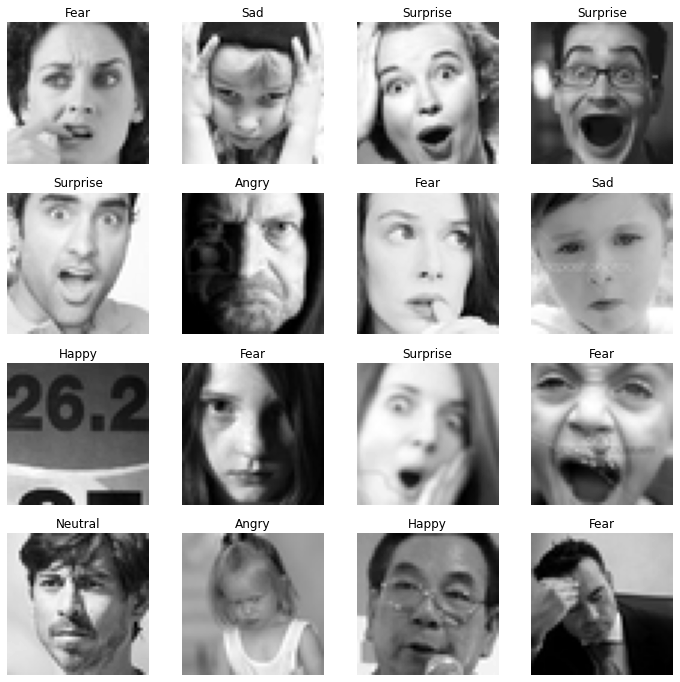

In [14]:
N_train = train_labels.shape[0]

sel = np.random.choice(range(N_train), replace=False, size=16)

X_sel = train_images[sel, :, :, :]
y_sel = train_labels[sel]

plt.figure(figsize=[12,12])
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_sel[i,:,:,0], cmap='binary_r')
    plt.title(emotions[y_sel[i]])
    plt.axis('off')
plt.show()

In [18]:
def preprocess(train_images, valid_images, train_labels, valid_labels):
    
#     shape =  np.array([48,48,1]) # put the size here.
#     shape = shape.astype(np.int64)
#     shape = tuple(shape)
#     print(shape)


    model = Sequential()
    model.add(Conv2D(64, (3,3), input_shape = (48,48,1), strides = 1, padding = "same"))
    model.add(BatchNormalization())
    model.add(layers.Activation(activations.relu))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, (3,3), strides = 1, padding = "same"))
    model.add(BatchNormalization())
    model.add(layers.Activation(activations.relu))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3,3), strides = 1,padding = "same"))
    model.add(BatchNormalization())
    model.add(layers.Activation(activations.relu))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3,3), strides = 1,padding = "same"))
    model.add(BatchNormalization())
    model.add(layers.Activation(activations.relu))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation = "relu", kernel_initializer = "uniform"))  #c check for kernal initilaiser
    model.add(BatchNormalization())
    model.add(layers.Activation(activations.relu))
    model.add(Dropout(0.5))
    model.add(Dense(512 ,activation = "relu", kernel_initializer = "uniform"))  #
    model.add(BatchNormalization())
    model.add(layers.Activation(activations.relu))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = "softmax", kernel_initializer = "uniform"))  #  check whether it needs activation or not.
    
    #return model

    
#     check_point = K.callbacks.ModelCheckpoint(filepath="emoji_prediction.h5",
#                                               monitor="val_acc",
#                                               mode="max",
#                                               save_best_only=True,
#                                               )
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=2e-5),  # change it to adagrad (lr = 0.001, initial_accumulator_valur = 0.1, epsilon = 1e-07)
                  metrics=['accuracy'])
    history = model.fit(train_images, train_labels, batch_size=32, epochs=10,
                        validation_data=(valid_images, valid_labels))
                        #callbacks=[TensorBoard(log_dir = 'logs/{}'.format(time.ctime()))])
    
    model.summary()
    model.save("emoji_prediction.h5")
    
    return history

# model = preprocess((48,48,64))
# print(model.summary())
    
    

In [19]:
# # reshaping ho chuka ha pehle hi..

# X_train = np.array([i for i in train_images])#.reshape(-1, 48, 48, 1) 
# print(train_images)
# print("hello")
# print(X_train)
# y_train = to_categorical([int(i) for i in train_labels])
# X_valid = np.array([i[0 for i in valid_images])#.reshape(-1, 45, 45, 1)
# y_valid = to_categorical([int(i) for i in valid_labels])

# X_train = X_train.astype('float32')
# X_valid = X_valid.astype('float32')

In [20]:
no_of_train_images = len(train_images)
print(no_of_train_images)
print(train_images[0].shape)
preprocess(train_images, valid_images, train_labels, valid_labels)


22967
(48, 48, 1)
Epoch 1/10
 11/718 [..............................] - ETA: 50:20 - loss: 2.1722 - accuracy: 0.1676

KeyboardInterrupt: 

In [78]:
no_of_valid_images = len(valid_images)
print(no_of_valid_images)

5742
